In [1]:
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier, early_stopping

from mrmr import mrmr_classif

from lightgbm import *
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

import optuna
from optuna.samplers import TPESampler

from hyperopt import hp
from hyperopt import Trials

import warnings
warnings.simplefilter('ignore')

In [2]:
class CFG:
    n_folds=10
    target_cols='Exited'
    feat_cols=['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'CustomerId']
    redundant_cols=['REDUNDANT_Age']
    rand_noise_cols=[f"RANDOM_{c}" for c in range(1, 6)]
    seed=7113

In [3]:
### READ DATA ###

train_df = pd.read_csv("Churn Modeling.csv", index_col='RowNumber').reset_index(drop=True)
train_df.drop(['Surname'], axis=1, inplace=True)

print(train_df.shape)
train_df.head()

(10000, 12)


,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
### CONVERT CATEGORICAL COLUMNS ###

cat_cols = list(train_df.head().select_dtypes(object).columns)
train_df[cat_cols] = train_df[cat_cols].astype("category")

In [5]:
### ADD RANDOM REDUNDANT FEATURES ###

np.random.seed(7113)

train_df["REDUNDANT_Age"] = train_df["Age"] + np.random.random_integers(0, 5, (train_df.shape[0],))

In [6]:
### ADD RANDOM ARTIFICIAL FEATURES ###

np.random.seed(7113)

for c in range(1,6):
    train_df[f"RANDOM_{c}"] = np.random.normal(0,5, (train_df.shape[0],1))

In [7]:
### CREATE K FOLD STRATIFIED FOLDS ###
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

n_fold = 0
train_df['fold'] = 0
for train_index, val_index in skf.split(train_df, train_df[CFG.target_cols]):
    train_df.loc[val_index, 'fold'] = n_fold
    n_fold += 1

In [8]:
### CV Recursive Feature Elimination ###
def binary_logloss(y_true, y_hat):
    return 'binary_logloss', log_loss(y_true, np.round(y_hat)), True

params = {  
        'objective': 'binary',
        'metric': "binary_logloss",
        'is_unbalance': True,
        'seed': CFG.seed,
        "boosting_type": "gbdt",
        'verbose': -1
        }

rfe_results = {}
rfa_resutls = {}
brute_results = {}

for fold in tqdm(range(CFG.n_folds)):
    
    print(f"--- {fold} fold ---")
    X_train, y_train = train_df.loc[train_df['fold'] != fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] != fold, CFG.target_cols]
    X_val, y_val = train_df.loc[train_df['fold'] == fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] == fold, CFG.target_cols]

    classifier = LGBMClassifier(**params)

    print(f"--- start RFE ---")
    modelRFE = BoostRFE(
        classifier,
        #min_features_to_select=None,  # the minimum number of features to be selected  
        step=1,  # number of features to remove at each iteration
        param_grid=None, 
        greater_is_better=False,
        importance_type='shap_importances',  # which importance measure to use: default or shap  
        train_importance=False,  # Where to compute the shap feature importance: on train (True) or on eval_set (False), default=True.
        #n_iter=10000,  # Effective only when hyperparameters searching.
        sampling_seed=CFG.seed,
        verbose=1,
        n_jobs=-1,
    )

    modelRFE.fit(
        X=X_train, y=y_train, 
        #trials=Trials(), 
        eval_set=[(X_val, y_val)], 
        callbacks=[early_stopping(150, verbose=False)], eval_metric=binary_logloss
    )
    y_preds_RFE = modelRFE.predict_proba(X_val)[:, 1]
    rfe_results[f"{fold} fold"] = modelRFE.support_

    print(f"--- start RFA ---")
    modelRFA = BoostRFA(
        classifier,
        #min_features_to_select=None,  # the minimum number of features to be selected  
        step=1,  # number of features to remove at each iteration
        param_grid=None, 
        greater_is_better=False,
        importance_type='shap_importances',  # which importance measure to use: default or shap  
        train_importance=False,  # Where to compute the shap feature importance: on train (True) or on eval_set (False), default=True.
        #n_iter=10000,  # Effective only when hyperparameters searching.
        sampling_seed=CFG.seed,
        verbose=1,
        n_jobs=-1,   
    )

    modelRFA.fit(
        X=X_train, y=y_train, 
        #trials=Trials(), 
        eval_set=[(X_val, y_val)], 
        callbacks=[early_stopping(150, verbose=False)], eval_metric=binary_logloss
    )
    y_preds_RFA = modelRFA.predict_proba(X_val)[:, 1]
    rfa_resutls[f"{fold} fold"] = modelRFA.support_

    print(f"--- start Brute Force ---")
    modelBruteForce = BoostBoruta(
        classifier,
        perc=80,  # threshold used to compare shadow and real features
        alpha=0.025,  # p-value levels for feature rejection
        max_iter=300,  # maximum Boruta iterations to perform
        #n_iter=10000,  # Effective only when hyperparameters searching.
        sampling_seed=CFG.seed,
        verbose=1,
        n_jobs=-1,
    )

    modelBruteForce.fit(
        X=X_train, y=y_train, 
        #trials=Trials(), 
        eval_set=[(X_val, y_val)], 
        callbacks=[early_stopping(150, verbose=False)], eval_metric=binary_logloss
    )
    y_preds_BF = modelBruteForce.predict_proba(X_val)[:, 1]  # fitted model is broken, so we can't use it for prediction
    brute_results[f"{fold} fold"] = modelBruteForce.support_



  0%|          | 0/10 [00:00<?, ?it/s]

--- 0 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 1 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 2 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 3 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 4 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 5 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 6 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 7 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 8 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---
--- 9 fold ---
--- start RFE ---
--- start RFA ---
--- start Brute Force ---


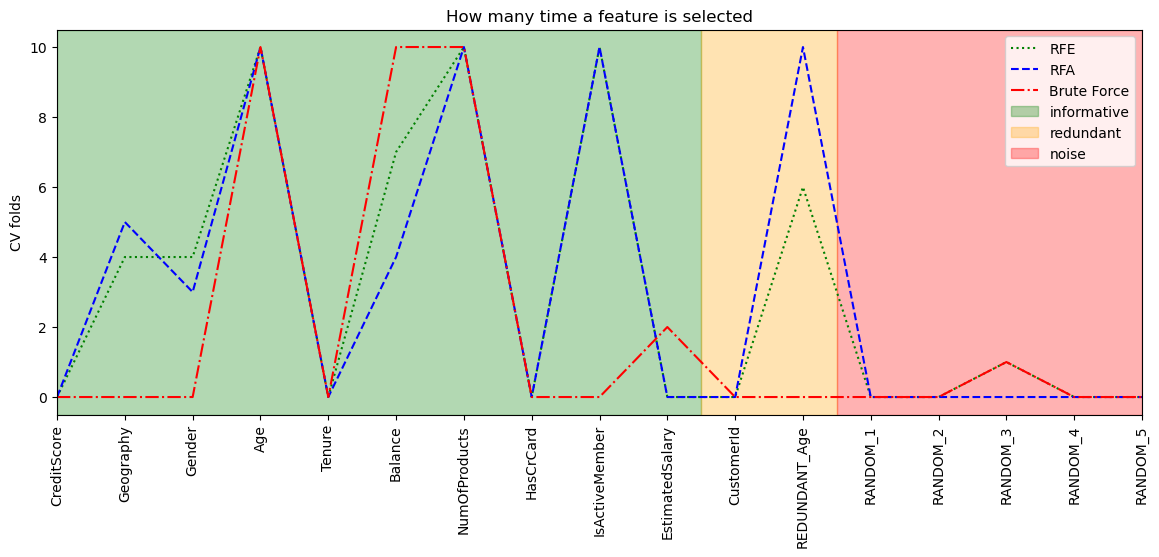

In [9]:
### SELECTED FEATURES ###
import matplotlib.pyplot as plt
n_feat = len(CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols)

plt.figure(figsize=(14, 5))
plt.plot(
    range(n_feat), 
    np.sum(list(rfe_results.values()), axis=0), 
    label='RFE', c='green', linestyle=':'
)
plt.plot(
    range(n_feat), 
    np.sum(list(rfa_resutls.values()), axis=0), 
    label='RFA', c='blue', linestyle='--'
)
plt.plot(
    range(n_feat), 
    np.sum(list(brute_results.values()), axis=0), 
    label='Brute Force', c='red', linestyle='-.'
)



plt.xlim(0, n_feat-1)
plt.ylim(-0.5, len(rfe_results) + 0.5)
plt.axvspan(0, 9.5, alpha=0.3, color='green', label='informative')
plt.axvspan(9.5, 11.5, alpha=0.3, color='orange', label='redundant')
plt.axvspan(11.5, 16, alpha=0.3, color='red', label='noise')
plt.xticks(range(n_feat), CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols, rotation=90)
plt.title('How many time a feature is selected')
plt.ylabel('CV folds')
plt.legend(); plt.show()

In [10]:
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives (Exit)','Negatives (Not Exit)']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)

In [11]:

CV_RFE_results = []
train_df['RFE_oof'] = 0
for fold in tqdm(range(CFG.n_folds)):
    
    print(f"--- {fold} fold ---")
    X_train, y_train = train_df.loc[train_df['fold'] != fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] != fold, CFG.target_cols]
    X_val, y_val = train_df.loc[train_df['fold'] == fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] == fold, CFG.target_cols]


    lgbm_RFE = LGBMClassifier(**params)
    lgbm_RFE.fit(X_train.loc[:, ['Age', 'NumOfProducts', 'Balance', 'IsActiveMember']], y_train, eval_set=[(X_val.loc[:, ['Age', 'NumOfProducts', 'Balance', 'IsActiveMember']], y_val)], eval_metric=binary_logloss)
    y_preds_RFE = lgbm_RFE.predict_proba(X_val.loc[:, ['Age', 'NumOfProducts', 'Balance', 'IsActiveMember']])[:, 1]
    train_df.loc[train_df['fold'] == fold, 'RFE_oof'] = y_preds_RFE

    CV_RFE_results.append(roc_auc_score(y_val, y_preds_RFE))



  0%|          | 0/10 [00:00<?, ?it/s]

--- 0 fold ---
--- 1 fold ---
--- 2 fold ---
--- 3 fold ---
--- 4 fold ---
--- 5 fold ---
--- 6 fold ---
--- 7 fold ---
--- 8 fold ---
--- 9 fold ---


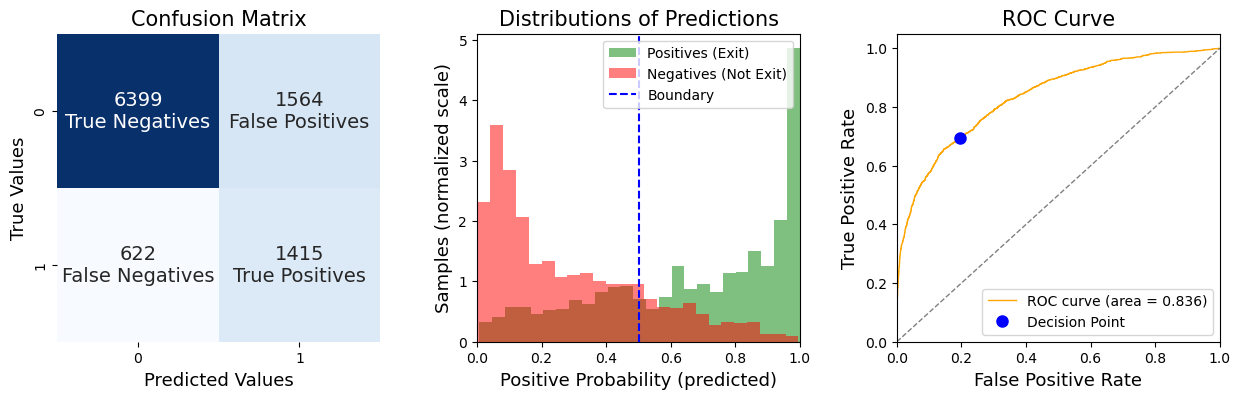

Precision: 0.475 | Recall: 0.695 | F1 Score: 0.564 | AUC: 0.836


In [12]:
binary_performances(train_df[CFG.target_cols].values, train_df['RFE_oof'].values)

In [13]:
CV_RFA_results = []
train_df['RFA_oof'] = 0
for fold in tqdm(range(CFG.n_folds)):
    
    print(f"--- {fold} fold ---")
    X_train, y_train = train_df.loc[train_df['fold'] != fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] != fold, CFG.target_cols]
    X_val, y_val = train_df.loc[train_df['fold'] == fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] == fold, CFG.target_cols]


    lgbm_RFA = LGBMClassifier(**params)
    lgbm_RFA.fit(X_train.loc[:, ['Age', 'NumOfProducts', 'IsActiveMember', 'REDUNDANT_Age']], y_train, eval_set=[(X_val.loc[:, ['Age', 'NumOfProducts', 'IsActiveMember', 'REDUNDANT_Age']], y_val)], eval_metric=binary_logloss)
    y_preds_RFA = lgbm_RFA.predict_proba(X_val.loc[:, ['Age', 'NumOfProducts', 'IsActiveMember', 'REDUNDANT_Age']])[:, 1]
    train_df.loc[train_df['fold'] == fold, 'RFA_oof'] = y_preds_RFA

    CV_RFA_results.append(roc_auc_score(y_val, y_preds_RFA))



  0%|          | 0/10 [00:00<?, ?it/s]

--- 0 fold ---
--- 1 fold ---
--- 2 fold ---
--- 3 fold ---
--- 4 fold ---
--- 5 fold ---
--- 6 fold ---
--- 7 fold ---
--- 8 fold ---
--- 9 fold ---


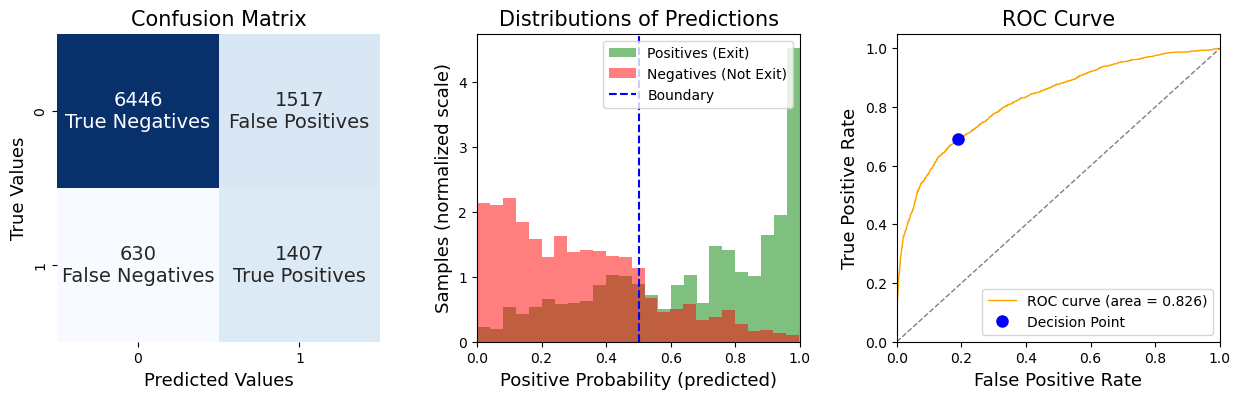

Precision: 0.481 | Recall: 0.691 | F1 Score: 0.567 | AUC: 0.826


In [14]:
binary_performances(train_df[CFG.target_cols].values, train_df['RFA_oof'].values)

In [15]:

CV_BF_results = []
train_df['BF_oof'] = 0
for fold in tqdm(range(CFG.n_folds)):
    
    print(f"--- {fold} fold ---")
    X_train, y_train = train_df.loc[train_df['fold'] != fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] != fold, CFG.target_cols]
    X_val, y_val = train_df.loc[train_df['fold'] == fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] == fold, CFG.target_cols]

    lgbm_BF = LGBMClassifier(**params)
    lgbm_BF.fit(X_train.loc[:, ['Age', 'Balance', 'NumOfProducts']], y_train, eval_set=[(X_val.loc[:, ['Age', 'Balance', 'NumOfProducts']], y_val)], eval_metric=binary_logloss)
    y_preds_BF = lgbm_BF.predict_proba(X_val.loc[:, ['Age', 'Balance', 'NumOfProducts']])[:, 1]
    train_df.loc[train_df['fold'] == fold, 'BF_oof'] = y_preds_BF

    CV_BF_results.append(roc_auc_score(y_val, y_preds_BF))

  0%|          | 0/10 [00:00<?, ?it/s]

--- 0 fold ---
--- 1 fold ---
--- 2 fold ---
--- 3 fold ---
--- 4 fold ---
--- 5 fold ---
--- 6 fold ---
--- 7 fold ---
--- 8 fold ---
--- 9 fold ---


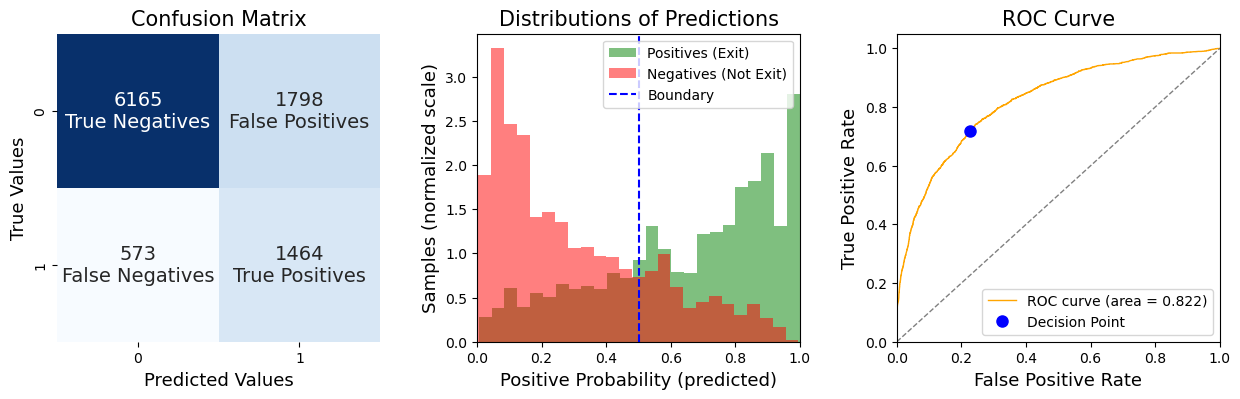

Precision: 0.449 | Recall: 0.719 | F1 Score: 0.553 | AUC: 0.822


In [16]:
binary_performances(train_df[CFG.target_cols].values, train_df['BF_oof'].values)

In [17]:
X_train['Geography'] = X_train['Geography'].map({'France': 0, 'Germany': 1, 'Spain': 2})
X_train['Gender'] = X_train['Gender'].map({'Female': 0, 'Male': 1})

In [18]:
selected_features = mrmr_classif(X=X_train, y=y_train, K=4)

100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


In [19]:
selected_features

['Age', 'Balance', 'Gender', 'IsActiveMember']

In [20]:

CV_mRMR_results = []
train_df['mRMR_oof'] = 0
for fold in tqdm(range(CFG.n_folds)):
    
    print(f"--- {fold} fold ---")
    X_train, y_train = train_df.loc[train_df['fold'] != fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] != fold, CFG.target_cols]
    X_val, y_val = train_df.loc[train_df['fold'] == fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] == fold, CFG.target_cols]

    lgbm_mRMR = LGBMClassifier(**params)
    lgbm_mRMR.fit(X_train.loc[:, ['Age', 'Balance', 'NumOfProducts']], y_train, eval_set=[(X_val.loc[:, ['Age', 'Balance', 'NumOfProducts']], y_val)], eval_metric=binary_logloss)
    y_preds_mRMR = lgbm_mRMR.predict_proba(X_val.loc[:, ['Age', 'Balance', 'NumOfProducts']])[:, 1]
    train_df.loc[train_df['fold'] == fold, 'mRMR_oof'] = y_preds_mRMR

    CV_mRMR_results.append(roc_auc_score(y_val, y_preds_mRMR))

  0%|          | 0/10 [00:00<?, ?it/s]

--- 0 fold ---
--- 1 fold ---
--- 2 fold ---
--- 3 fold ---
--- 4 fold ---
--- 5 fold ---
--- 6 fold ---
--- 7 fold ---
--- 8 fold ---
--- 9 fold ---


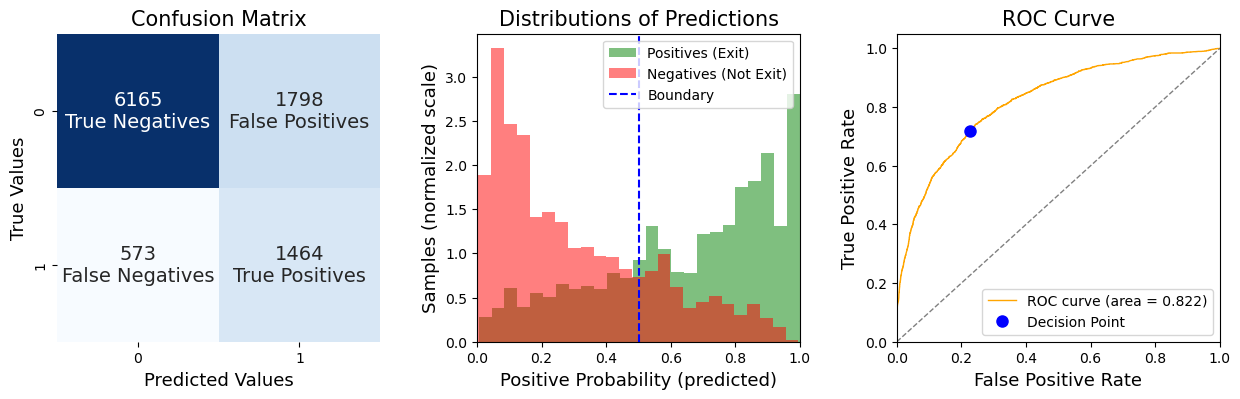

Precision: 0.449 | Recall: 0.719 | F1 Score: 0.553 | AUC: 0.822


In [21]:
binary_performances(train_df[CFG.target_cols].values, train_df['mRMR_oof'].values)

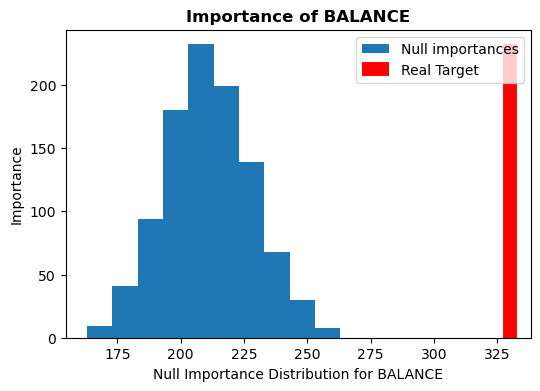

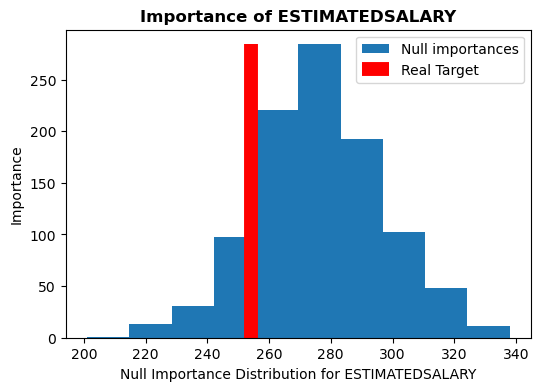

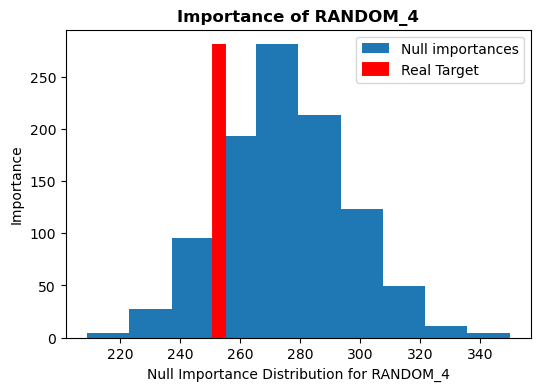

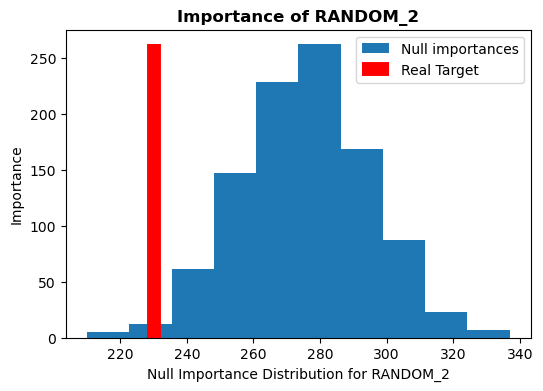

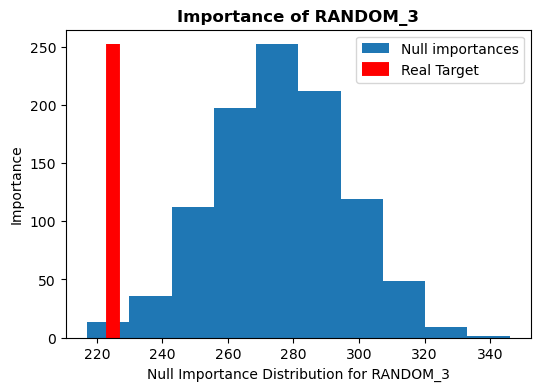

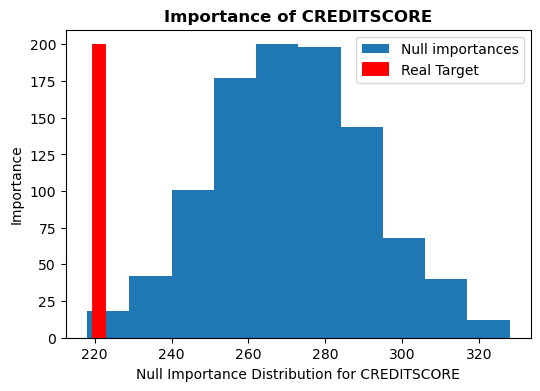

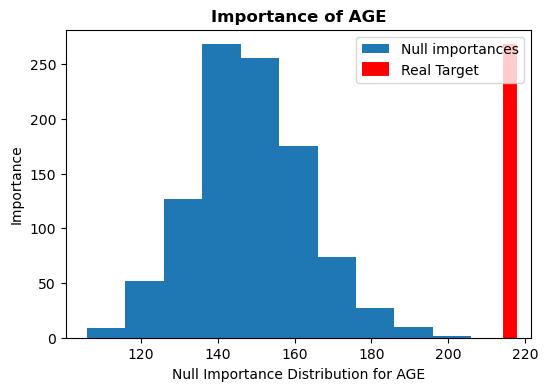

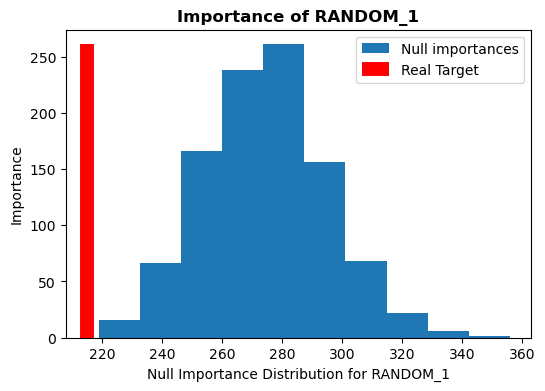

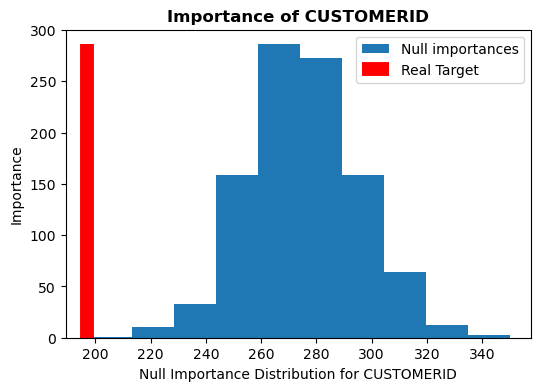

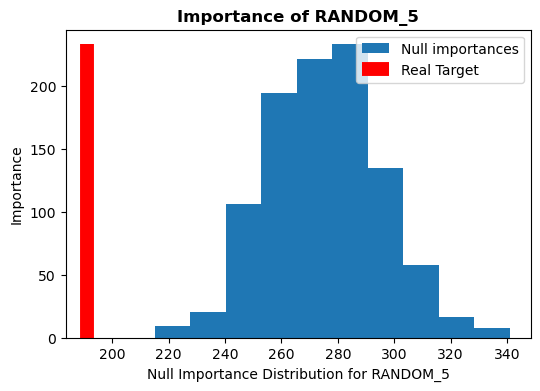

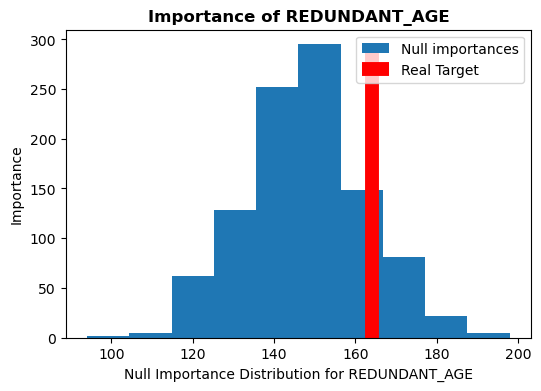

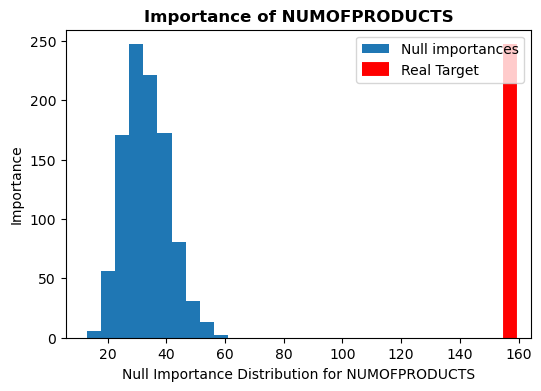

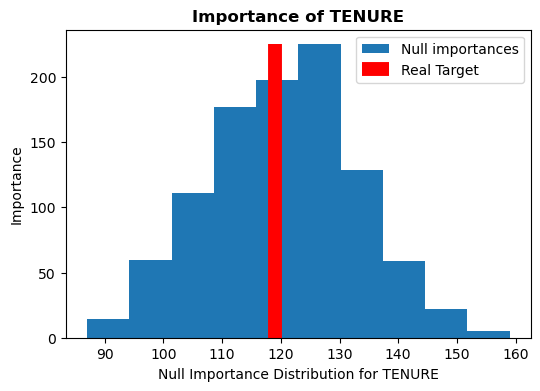

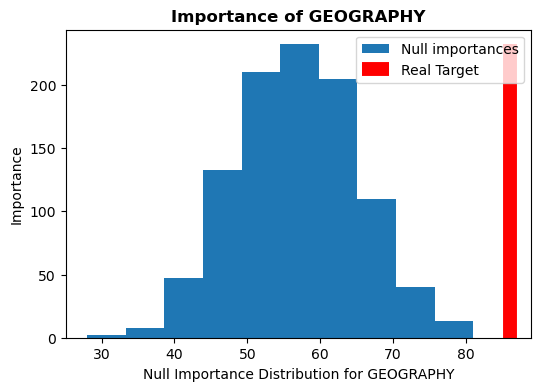

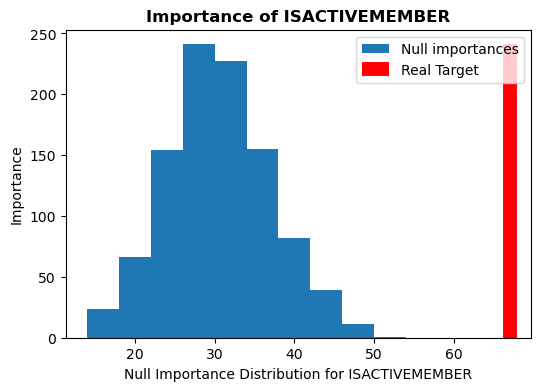

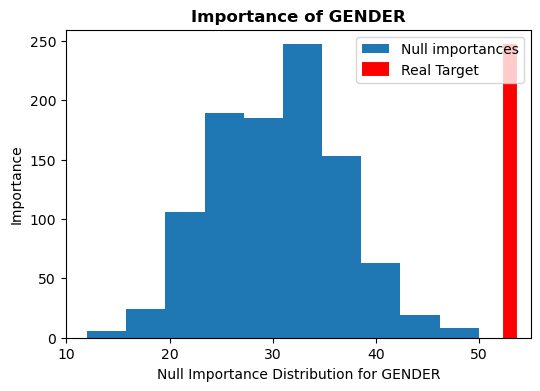

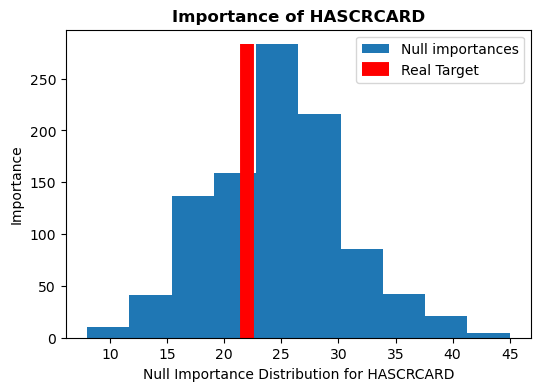

In [22]:

def get_feature_importances(X, y, shuffle=False):

    if shuffle:
        y = np.random.permutation(y)

    clf = LGBMClassifier(**params)
    clf.fit(X, y)

    imp_df = pd.DataFrame()
    imp_df["feature"] = X.columns
    imp_df["importance"] = clf.feature_importances_
    return imp_df.sort_values("importance", ascending=False)


actual_imp_df = get_feature_importances(X_train.loc[:, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], y_train, shuffle=False)


N_RUNS = 1000
null_imp_df = pd.DataFrame()
for i in range(N_RUNS):
    imp_df = get_feature_importances(X_train.loc[:, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], y_train, shuffle=True)
    imp_df["run"] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df])


def display_distributions(actual_imp_df, null_imp_df, feature):

    actual_imp = actual_imp_df.query(f"feature == '{feature}'")["importance"].mean()
    null_imp = null_imp_df.query(f"feature == '{feature}'")["importance"]

    # 可視化
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    a = ax.hist(null_imp, label="Null importances")
    ax.vlines(x=actual_imp, ymin=0, ymax=np.max(a[0]), color='r', linewidth=10, label='Real Target')
    ax.legend(loc="upper right")
    ax.set_title(f"Importance of {feature.upper()}", fontweight='bold')
    plt.xlabel(f"Null Importance Distribution for {feature.upper()}")
    plt.ylabel("Importance")
    plt.show()


for feature in actual_imp_df["feature"][:]:
    display_distributions(actual_imp_df, null_imp_df, feature)

In [23]:
CV_ALL_results = []
train_df['ALL_oof'] = 0
for fold in tqdm(range(CFG.n_folds)):
    
    print(f"--- {fold} fold ---")
    X_train, y_train = train_df.loc[train_df['fold'] != fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] != fold, CFG.target_cols]
    X_val, y_val = train_df.loc[train_df['fold'] == fold, CFG.feat_cols + CFG.redundant_cols + CFG.rand_noise_cols], train_df.loc[train_df['fold'] == fold, CFG.target_cols]


    lgbm_ALL = LGBMClassifier(**params)
    lgbm_ALL.fit(X_train.loc[:, ['Age', 'NumOfProducts', 'IsActiveMember', 'REDUNDANT_Age']], y_train, eval_set=[(X_val.loc[:, ['Age', 'NumOfProducts', 'IsActiveMember', 'REDUNDANT_Age']], y_val)], eval_metric=binary_logloss)
    y_preds_ALL = lgbm_ALL.predict_proba(X_val.loc[:, ['Age', 'NumOfProducts', 'IsActiveMember', 'REDUNDANT_Age']])[:, 1]
    train_df.loc[train_df['fold'] == fold, 'ALL_oof'] = y_preds_ALL

    CV_ALL_results.append(roc_auc_score(y_val, y_preds_ALL))

  0%|          | 0/10 [00:00<?, ?it/s]

--- 0 fold ---
--- 1 fold ---
--- 2 fold ---
--- 3 fold ---
--- 4 fold ---
--- 5 fold ---
--- 6 fold ---
--- 7 fold ---
--- 8 fold ---
--- 9 fold ---


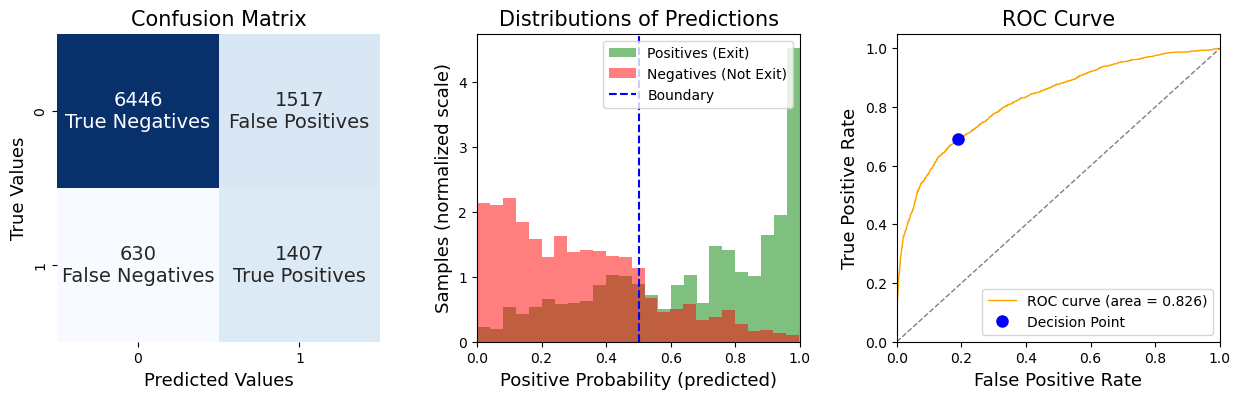

Precision: 0.481 | Recall: 0.691 | F1 Score: 0.567 | AUC: 0.826


In [24]:
binary_performances(train_df[CFG.target_cols].values, train_df['ALL_oof'].values)